In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import pandas as pd
from astropy.io import fits
from astropy.time import Time, TimeDelta

import sys
sys.path.append("/home/sandboxes/psalas/PTCS/AutoOOF/oof_au")

import scan_log
import oof_analysis
import peak_analysis

sys.path.append("/home/scratch/psalas/python/music_cmaps")
import music_cmaps

In [3]:
path = {"A":"/home/archive/science-data/",
        "T":"/home/archive/test-data/"}

In [4]:
df = pd.read_hdf("auto-oof-scans-15A_22A-20092022.hdf", "auto-oof")

In [5]:
len(df)

941

In [ ]:
%%time

projs = []
aoofs = []
scans = []
scant = [] # Scan type
times = []
aprms = []
ftau0 = []
peaks = []
oofmj = []
vscan = []
sscan = []
thrmz = []
aosrc = []
pksrc = []

idx0 = 0
idxf = len(df)

for idx in range(idx0,idxf):
    
    print(f"Index: {idx}")
    
    pid = df.at[idx, "id"]
    
    if pid[0] == "T":
        continue

    projid = "_".join(pid.split("_")[:-1])
    print(projid)
    project = "_".join(pid.split("_")[:-2])
    print(f"Project: {project}")
    session = pid.split("_")[2]
    print(f"Session: {session}")
    semester = pid.split("_")[0][-3:]
    print(f"Semester: {semester}")
    if pid[0] == "T":
        semester = f"20{semester[:-1]}"
    oof_scan = int(pid.split("_")[-1][1:])
    print(f"AutoOOF scan: {oof_scan}")

    proj_path = f"{path[pid[0]]}/{semester}"
    print(proj_path)

    try:
        sl = scan_log.ScanLog(proj_path, projid)
    except FileNotFoundError:
        #proj_path = f"{path[pid[0]]}/{int(semester)+1}"
        #sl = scan_log.ScanLog(proj_path, projid)
        print("Scan log not found...")
        continue

    peak_scan_dict = peak_analysis.find_vane_peak_scans(sl)
    print(peak_scan_dict)
    
    if len(peak_scan_dict["vane"]) == 0 or \
       len(peak_scan_dict["sky"]) == 0 or \
       len(peak_scan_dict["peak"]) == 0:
        continue
        
    # Get source for OOF.
    go_file = sl.get_scan_files(oof_scan, "GO")
    hdu = fits.open(go_file)
    oof_src = hdu[0].header["OBJECT"]
    
    scans_ = []
    times_ = []
    aprms_ = []
    ftau0_ = []
    peaks_ = []
    projs_ = []
    oofss_ = []
    oofmj_ = []
    aosrc_ = []
    scant_ = []
    vscan_ = []
    sscan_ = []
    thrmz_ = []
    pksrc_ = []
    scant_aux = []
    
    fsi = 0
    for i,vs in enumerate(peak_scan_dict["vane"]):
        if vs > oof_scan:
            peak_scans_idx = np.argmin(abs(peak_scan_dict["peak"] - vs))
            peak_scans = peak_scan_dict["peak"][peak_scans_idx:peak_scans_idx+4]
            peak_src = peak_scan_dict["peak_src"][peak_scans_idx:peak_scans_idx+4]

            if peak_scans[0] < vs:
                peak_scans = peak_scan_dict["peak"][peak_scans_idx+1:peak_scans_idx+1+4]
                peak_src = peak_scan_dict["peak_src"][peak_scans_idx+1:peak_scans_idx+1+4]

            # Check if there is a gap in peak scans.
            # This usually means the peak was aborted.
            dps = np.diff(peak_scans)
            if np.any(dps > 1):
                #print(np.where(dps > 1)[0])
                peak_scans = peak_scans[:np.where(dps > 1)[0][0]+1]
                peak_src = peak_src[:np.where(dps > 1)[0][0]+1]
                
            if len(peak_scans) == 0:
                print("No peak scans associated with the Vane scan.")
                continue

            scant_aux.append(["p"]*len(peak_scans))
                
            if len(peak_scan_dict["focus"]) > 0 \
               and (fsi < len(peak_scan_dict["focus"])):
                if (peak_scan_dict["focus"][fsi] - peak_scans[-1]) == 1:
                    peak_scans += peak_scan_dict["focus"][fsi:fsi+1]
                    peak_src += peak_scan_dict["focus_src"][fsi:fsi+1]
                    fsi += 1
                    scant_aux.append("f")
                
                    
            # What if a CALSEQ was aborted?
            sky_scan = peak_scan_dict['sky'][np.argmin(abs(vs - peak_scan_dict['sky']))]
                    
            print(f"Peak scans: {peak_scans}")
            print(f"Vane scan: {vs}")
            print(f"Sky scan: {sky_scan}")

            if True:
                ap = peak_analysis.AutoPeak(vs,
                                            sky_scan,
                                            peak_scans,
                                            sl)
                try:
                    peak_ta_dict = ap.get_peak_ta("RcvrArray75_115")
                except (FileNotFoundError, TypeError):
                    print("Could not find a file while computing peaks.")
                    continue
                print(peak_ta_dict)
                oofa = oof_analysis.OOFAnalysis(proj_path, project, session)
                oof_dict = {}
                for scan,ta in peak_ta_dict.items():
                    try:
                        rms = oofa.compute_surface_rms(scan, ta, verbose=False)
                    except AttributeError:
                        print("Could not estimate rms")
                        break
                    oof_dict[scan] = [ta, rms["rms"], rms["tau0"]]

                print(oof_dict)

                for scan, [ta, rms, tau0] in oof_dict.items():
                    vscan_.append(vs)
                    sscan_.append(sky_scan)
                    scans_.append(scan)
                    aprms_.append(rms)
                    ftau0_.append(tau0)
                    peaks_.append(ta)
                    times_.append(Time(sl.get_scan_dateobs(scan)).mjd)
                    projs_.append(projid)
                    oofss_.append(oof_scan)
                    oofmj_.append(Time(sl.get_scan_dateobs(oof_scan)).mjd)
                    aosrc_.append(oof_src)
                    
                    
                    # Get thermal Zernike.
                    as_file = sl.get_scan_files(scan, "ActiveSurfaceMgr")
                    try:
                        hdu = fits.open(as_file)
                    except FileNotFoundError:
                        z = np.nan
                    try:
                        z = hdu["THRMZERN"].data["Value"]
                    except:
                        z = np.nan
                    thrmz_.append(z)
                    
                scant_.append(list(itertools.chain.from_iterable(scant_aux)))
                scant_aux = []
                
                pksrc_.append(peak_src)
    
    # Only take note of these things 
    # if everything went well.
    projs.append(projs_)
    aoofs.append(oofss_)
    oofmj.append(oofmj_)
    aosrc.append(aosrc_)
    scans.append(scans_)
    times.append(times_)
    aprms.append(aprms_)
    ftau0.append(ftau0_)
    peaks.append(peaks_)
    pksrc.append(pksrc_)
    scant.append(scant_)
    vscan.append(vscan_)
    sscan.append(sscan_)
    thrmz.append(thrmz_)

Index: 0
AGBT15A_075_01
Project: AGBT15A_075
Session: 01
Semester: 15A
AutoOOF scan: 1
/home/archive/science-data//15A
{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51], 'focus': [8, 15, 21, 26, 35, 42, 47, 52], 'peak_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'peak_src': ['2015+3710', '2015+3710', '2015+3710', '2015+3710', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0

{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 14, 15, 16, 17, 23, 24, 25, 26, 32, 33, 34, 35, 43, 44, 45, 46, 51, 52, 53, 54, 62, 63, 64, 65, 71, 72, 73, 74], 'focus': [8, 18, 27, 36, 47, 55, 66, 75], 'peak_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'peak_src': ['2015+3710', '2015+3710', '2015+3710', '2015+3710', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0001', '1850-0

{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 11, 12, 13, 14, 19, 20, 21, 22, 25, 26, 27, 28, 34, 35, 36, 37], 'focus': [8, 15, 23, 29, 38], 'peak_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'peak_src': ['2015+3710', '2015+3710', '2015+3710', '2015+3710', '2015+3710', '2015+3710', '2015+3710', '2015+3710', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939', '1751+0939'], 'focus_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'focus_src': ['2015+3710', '2015+3710', '1751+0939', '1751+0939', '1751+0939']}
Index: 16
AGBT15A_159_01
Project: AGBT15A_159
Session: 01
Semester: 15A
AutoOOF scan: 2
/home/archive/science-data//15A
{'vane': [], 'sky': [], 'peak': [6

{'vane': [], 'sky': [], 'peak': [10, 11, 12, 13, 22, 23, 24, 25, 29, 30, 31, 32, 36, 37, 38, 39, 43, 44, 45, 46, 142, 143, 144, 145], 'focus': [15, 27, 34, 41, 48, 147], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'peak_src': ['2202+4216', '2202+4216', '2202+4216', '2202+4216', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0217+7349', '0102+5824', '0102+5824', '0102+5824', '0102+5824', '0136+4751', '0136+4751', '0136+4751', '0136+4751'], 'focus_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'focus_src': ['2202+4216', '0217+7349', '0217+7349', '0217+7349', '0102+5824', '0136+47

{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 31, 32, 33, 34, 48, 49, 50, 51], 'focus': [8, 13, 18, 35, 52], 'peak_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'peak_src': ['0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600', '0403+2600'], 'focus_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'focus_src': ['0319+4130', '0319+4130', '0403+2600', '0403+2600', '0403+2600']}
Index: 35
AGBT15A_162_02
Project: AGBT15A_162
Session: 02
Semester: 15A
AutoOOF scan: 1
/home/archive/science-data//15A
{'vane': [], 'sky': [], 'peak': [4,

{'vane': [], 'sky': [], 'peak': [2, 3, 4, 5], 'focus': [6], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'peak_src': ['0854+2006', '0854+2006', '0854+2006', '0854+2006'], 'focus_rx': ['Rcvr68_92'], 'focus_src': ['0854+2006']}
Index: 40
AGBT15A_322_02
Project: AGBT15A_322
Session: 02
Semester: 15A
AutoOOF scan: 8
/home/archive/science-data//15A
{'vane': [], 'sky': [], 'peak': [2, 3, 4, 5], 'focus': [6], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'peak_src': ['0854+2006', '0854+2006', '0854+2006', '0854+2006'], 'focus_rx': ['Rcvr68_92'], 'focus_src': ['0854+2006']}
Index: 41
AGBT15A_411_03
Project: AGBT15A_411
Session: 03
Semester: 15A
AutoOOF scan: 2
/home/archive/science-data//15A
{'vane': [], 'sky': [], 'peak': [5, 6, 7, 8, 11, 12, 13, 14, 16, 17, 18, 19], 'focus': [9, 15, 20], 'peak_rx': ['Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40', 'Rcvr26_40'],

{'vane': [], 'sky': [], 'peak': [6, 7, 8, 9, 16, 17, 18, 19, 21, 22, 23, 24, 43, 44, 45, 46, 49, 50, 51, 52, 79, 80, 81, 82, 109, 110, 111, 112, 139, 140, 141, 142, 145, 146, 147, 148], 'focus': [10, 25, 47, 53, 83, 113, 143, 149], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'peak_src': ['0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0336+3218', '0336+3218', '0336+3218', '0336+3218', '0336+3218', '

{'vane': [], 'sky': [], 'peak': [6, 7, 8, 9, 12, 13, 15, 16, 17, 18, 73, 74, 76, 77, 78, 79], 'focus': [10, 19, 80], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'peak_src': ['1153+4931', '1153+4931', '1153+4931', '1153+4931', '1153+4931', '1153+4931', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1310+3220', '1310+3220', '1229+0203', '1229+0203', '1229+0203', '1229+0203'], 'focus_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'focus_src': ['1153+4931', '1229+0203', '1229+0203']}
Index: 60
AGBT15B_244_02
Project: AGBT15B_244
Session: 02
Semester: 15B
AutoOOF scan: 3
/home/archive/science-data//15B
{'vane': [], 'sky': [], 'peak': [10, 11, 12, 13, 26, 27, 46, 47, 48, 49, 77, 78, 79, 80], 'focus': [14, 50, 81], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92

{'vane': [], 'sky': [], 'peak': [6, 7, 8, 9, 12, 13, 14, 15, 25, 26, 27, 28, 31, 32, 33, 34, 73, 74, 75, 76, 79, 80, 81, 82, 85, 86, 87, 88, 125, 126, 127, 128], 'focus': [10, 16, 29, 35, 77, 83, 89, 129], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'peak_src': ['J0854+2006', 'J0854+2006', 'J0854+2006', 'J0854+2006', 'J0854+2006', 'J0854+2006', 'J0854+2006', 'J0854+2006', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1159+2914', 'J1146+3958', 'J1146+3958', 'J1146+3958', 'J1146+3958', 'J1146+3958', 'J

{'vane': [], 'sky': [], 'peak': [6, 7, 8, 9, 12, 13, 14, 15, 65, 66, 67, 68, 71, 72, 73, 74, 113, 114, 115, 116], 'focus': [10, 16, 69, 75, 117], 'peak_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'peak_src': ['1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422'], 'focus_rx': ['Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92'], 'focus_src': ['1517-2422', '1517-2422', '1517-2422', '1517-2422', '1517-2422']}
Index: 77
AGBT16A_261_04
Project: AGBT16A_261
Session: 04
Semester: 16A
AutoOOF scan: 2
/home/archive/science-data//16A
{'vane': [], 'sky': [], 'pea

{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 10, 11, 12, 13, 30, 31, 32, 33, 62, 63, 64, 65], 'focus': [8, 14, 34, 66], 'peak_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'peak_src': ['1310+3220', '1310+3220', '1310+3220', '1310+3220', '1310+3220', '1310+3220', '1310+3220', '1310+3220', '1331+3030', '1331+3030', '1331+3030', '1331+3030', '1331+3030', '1331+3030', '1331+3030', '1331+3030'], 'focus_rx': ['Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52', 'Rcvr40_52'], 'focus_src': ['1310+3220', '1310+3220', '1331+3030', '1331+3030']}
Index: 84
AGBT16A_278_02
Project: AGBT16A_278
Session: 02
Semester: 16A
AutoOOF scan: 1
/home/archive/science-data//16A
{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 34, 35, 36, 37, 57, 58, 59, 60], 'focus': [25, 30, 38, 61], 'peak_rx': ['Rc

{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 51, 52, 53, 54], 'focus': [8, 15, 20, 55], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800', '0510+1800'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'focus_src': ['0510+1800', '0510+1800', '0510+1800', '0510+1800']}
Index: 94
AGBT16B_119_04
Project: AGBT16B_119
Session: 04
Semester: 16B
AutoOOF scan: 1
/home/archive/science-dat

{'vane': [], 'sky': [], 'peak': [9, 10, 11, 12, 16, 17, 18, 19, 55, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73], 'focus': [13, 20, 59, 69], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_11

{'vane': [], 'sky': [], 'peak': [7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 83, 84, 85, 86, 87, 88, 89, 90], 'focus': [15, 20, 33, 91], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1927+7358', '1927+7358', '1927+7358', '1927+7358', '2202+4216', '2202+4216', '2202+4216

{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 126
AGBT17A_271_05
Project: AGBT17A_271
Session: 05
Semester: 17A
AutoOOF scan: 17
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 127
AGBT17A_271_05
Project: AGBT17A_271
Session: 05
Semester: 17A
AutoOOF scan: 2
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 128
AGBT17A_271_05
Project: AGBT17A_271
Session: 05
Semester: 17A
AutoOOF scan: 21
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 129
AGBT17A_271_05
Project: AGBT17A_271
Session: 05
Semester: 17A
AutoOOF scan: 44
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [

{'vane': [], 'sky': [], 'peak': [12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24], 'focus': [20], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203'], 'focus_rx': ['RcvrArray75_115'], 'focus_src': ['1229+0203']}
Index: 137
AGBT17A_304_04
Project: AGBT17A_304
Session: 04
Semester: 17A
AutoOOF scan: 9
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24], 'focus': [20], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray7

{'vane': [], 'sky': [], 'peak': [9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26], 'focus': [13, 18, 27], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '1642+3948', '2253+1608', '2253+1608', '2253+1608', '2253+1608'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'focus_src': ['1642+3948', '1642+3948', '2253+1608']}
Index: 147
AGBT17A_304_10
Project: AGBT17A_304
Session: 10
Semester: 17A
AutoOOF scan: 6
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26]

{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 172
AGBT17A_358_03
Project: AGBT17A_358
Session: 03
Semester: 17A
AutoOOF scan: 28
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 173
AGBT17A_358_03
Project: AGBT17A_358
Session: 03
Semester: 17A
AutoOOF scan: 5
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 174
AGBT17A_358_04
Project: AGBT17A_358
Session: 04
Semester: 17A
AutoOOF scan: 2
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 175
AGBT17A_358_05
Project: AGBT17A_358
Session: 05
Semester: 17A
AutoOOF scan: 3
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [],

{11: [1.1136422215974906, <Quantity 308.94346559 um>, array([0.1748])], 12: [1.5488655246822163, <Quantity 282.81769478 um>, array([0.1747])], 13: [1.0546562262669799, <Quantity 313.04395807 um>, array([0.1747])], 14: [0.851501804343164, <Quantity 328.67035203 um>, array([0.1747])]}
Peak scans: [17, 18, 19, 20, 21]
Vane scan: 15
Sky scan: 16
{17: 0.6228469312423918, 18: 0.5609395207389449, 19: 0.8030362010916852, 20: 0.5898837363837779, 21: 1.0997554006298933}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{17: [0.6228469312423918, masked, array([0.1742])], 18: [0.5609395207389449, masked, array([0.1742])], 19: [0.8030362010916852, masked, array([0.1742])], 20: [0.5898837363837779, masked, array([0.1742])], 21: [1.0997554006298933, masked, array([0.1741])]}
Peak scans: [24, 25, 26, 27, 28]
Vane scan: 22
Sky scan: 23
{24: 1.3077743609937513, 25: 1.2637976026996138, 26: 1.034650494697239, 27: 1.630443256406262, 28: 1.5541260211001144}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{24: [1.3077743609937513, masked, array([0.1739])], 25: [1.2637976026996138, masked, array([0.1739])], 26: [1.034650494697239, masked, array([0.1738])], 27: [1.630443256406262, masked, array([0.1738])], 28: [1.5541260211001144, masked, array([0.1738])]}
Peak scans: [31, 32, 33, 34]
Vane scan: 29
Sky scan: 30
{31: 0.983446301595892, 32: 1.580106121443419, 33: 1.0757798814168216, 34: 1.2861908015448167}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{31: [0.983446301595892, masked, array([0.1736])], 32: [1.580106121443419, masked, array([0.1736])], 33: [1.0757798814168216, masked, array([0.1736])], 34: [1.2861908015448167, masked, array([0.1736])]}
Index: 202
AGBT17A_440_01
Project: AGBT17A_440
Session: 01
Semester: 17A
AutoOOF scan: 6
/home/archive/science-data//17A
{'vane': [1, 9, 15, 22, 29], 'sky': [2, 10, 16, 23, 30], 'peak': [11, 12, 13, 14, 17, 18, 19, 20, 24, 25, 26, 27, 31, 32, 33, 34], 'focus': [21, 28], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1642+3948', '1642+3948', '1642+3948', '1642+3948', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '

/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{17: [0.6228469312423918, masked, array([0.1742])], 18: [0.5609395207389449, masked, array([0.1742])], 19: [0.8030362010916852, masked, array([0.1742])], 20: [0.5898837363837779, masked, array([0.1742])], 21: [1.0997554006298933, masked, array([0.1741])]}
Peak scans: [24, 25, 26, 27, 28]
Vane scan: 22
Sky scan: 23
{24: 1.3077743609937513, 25: 1.2637976026996138, 26: 1.034650494697239, 27: 1.630443256406262, 28: 1.5541260211001144}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{24: [1.3077743609937513, masked, array([0.1739])], 25: [1.2637976026996138, masked, array([0.1739])], 26: [1.034650494697239, masked, array([0.1738])], 27: [1.630443256406262, masked, array([0.1738])], 28: [1.5541260211001144, masked, array([0.1738])]}
Peak scans: [31, 32, 33, 34]
Vane scan: 29
Sky scan: 30
{31: 0.983446301595892, 32: 1.580106121443419, 33: 1.0757798814168216, 34: 1.2861908015448167}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{31: [0.983446301595892, masked, array([0.1736])], 32: [1.580106121443419, masked, array([0.1736])], 33: [1.0757798814168216, masked, array([0.1736])], 34: [1.2861908015448167, masked, array([0.1736])]}
Index: 203
AGBT17A_440_02
Project: AGBT17A_440
Session: 02
Semester: 17A
AutoOOF scan: 3
/home/archive/science-data//17A
{'vane': [1, 6, 12, 19], 'sky': [2, 7, 13, 20], 'peak': [8, 9, 10, 11, 14, 15, 16, 17, 21, 22, 23, 24], 'focus': [18], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358', '1927+7358'], 'focus_rx': ['RcvrArray75_115'], 'focus_src': ['1927+7358']}
Peak scans: [8, 9, 10, 11]
Vane scan: 6
Sky scan: 7
{8: 0.3234953921511852, 9: 0.4097

/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{8: [0.3234953921511852, masked, array([0.1697])], 9: [0.4097219696868968, masked, array([0.17])], 10: [1.0431085351918656, masked, array([0.1704])], 11: [0.7438726368079884, masked, array([0.1707])]}
Peak scans: [14, 15, 16, 17, 18]
Vane scan: 12
Sky scan: 13
{14: 1.3832682411221193, 15: 1.383006568325495, 16: 1.318246535131011, 17: 1.344697271880481, 18: 1.5086255502808559}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{14: [1.3832682411221193, masked, array([0.1727])], 15: [1.383006568325495, masked, array([0.173])], 16: [1.318246535131011, masked, array([0.1733])], 17: [1.344697271880481, masked, array([0.1736])], 18: [1.5086255502808559, masked, array([0.1741])]}
Peak scans: [21, 22, 23, 24]
Vane scan: 19
Sky scan: 20
{21: 1.084303346858328, 22: 1.5694445642760213, 23: 1.0814590965936985, 24: 1.5677141534866588}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{21: [1.084303346858328, masked, array([0.1763])], 22: [1.5694445642760213, masked, array([0.1768])], 23: [1.0814590965936985, masked, array([0.1768])], 24: [1.5677141534866588, masked, array([0.1765])]}
Index: 204
AGBT17A_433_01
Project: AGBT17A_433
Session: 01
Semester: 17A
AutoOOF scan: 24
/home/archive/science-data//17A
{'vane': [], 'sky': [], 'peak': [12, 13, 14, 15, 28, 29, 30, 31, 33, 34, 35, 36, 42, 43, 44, 45, 53, 54, 55, 56], 'focus': [16, 32, 37, 46, 57], 'peak_rx': ['Rcvr8_10', 'Rcvr8_10', 'Rcvr8_10', 'Rcvr8_10', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'Rcvr68_92', 'RcvrArray18_26', 'RcvrArray18_26', 'RcvrArray18_26', 'RcvrArray18_26', 'Rcvr4_6', 'Rcvr4_6', 'Rcvr4_6', 'Rcvr4_6', 'Rcvr8_10', 'Rcvr8_10', 'Rcvr8_10', 'Rcvr8_10'], 'peak_src': ['1743-0350', '1743-0350', '1743-0350', '1743-0350', '1733-1304', '1733-1304', '1733-1304', '1733-1304', '1743-0350', '1743-0350', '1743-0350', '1743-0350', '1743-0350', '1743-0350', '1743-0350', '1743-0350', '1713-2658', '1713-2658', '1713

{8: [0.3906088389589993, <Quantity 424.28810732 um>, array([0.1132])], 9: [0.5654121517543236, <Quantity 391.72169603 um>, array([0.1137])], 10: [0.5552790724061748, <Quantity 393.37676023 um>, array([0.1142])], 11: [0.4327740742064168, <Quantity 415.51758225 um>, array([0.1147])]}
Peak scans: [14, 15, 16, 17]
Vane scan: 12
Sky scan: 13
{14: 0.4313773360300436, 15: 0.391940272194653, 16: 2.026199314331916, 17: 1.8232225689549153}
{14: [0.4313773360300436, <Quantity 415.79698573 um>, array([0.1173])], 15: [0.391940272194653, <Quantity 423.99987906 um>, array([0.1179])], 16: [2.026199314331916, <Quantity 248.46755133 um>, array([0.1185])], 17: [1.8232225689549153, <Quantity 263.2880499 um>, array([0.1189])]}
Peak scans: [20, 21, 22, 23, 24]
Vane scan: 18
Sky scan: 19
{20: 1.8894510154675157, 21: 1.8094490401933823, 22: 1.9123414698569445, 23: 2.206360373615432, 24: 2.3138171065931754}
{20: [1.8894510154675157, <Quantity 258.37346623 um>, array([0.1209])], 21: [1.8094490401933823, <Quanti

{116: 1.9237624370657662, 117: 1.9993126534805736, 118: 2.0724137103277043, 119: 1.8091904532848506, 120: 2.247749864414805}
{116: [1.9237624370657662, <Quantity 240.97030807 um>, array([0.0759])], 117: [1.9993126534805736, <Quantity 235.65199122 um>, array([0.0759])], 118: [2.0724137103277043, <Quantity 230.58357684 um>, array([0.0759])], 119: [1.8091904532848506, <Quantity 249.21338335 um>, array([0.0759])], 120: [2.247749864414805, <Quantity 218.68796522 um>, array([0.076])]}
Peak scans: [142, 143, 144, 145, 146]
Vane scan: 140
Sky scan: 141
{142: 1.4096261791544444, 143: 2.1307927602975196, 144: 1.8763487959024463, 145: 1.9020239672869197, 146: 1.8433715216558626}
{142: [1.4096261791544444, <Quantity 296.32224534 um>, array([0.0796])], 143: [2.1307927602975196, <Quantity 241.08011723 um>, array([0.0796])], 144: [1.8763487959024463, <Quantity 259.33923296 um>, array([0.0796])], 145: [1.9020239672869197, <Quantity 257.44961607 um>, array([0.0797])], 146: [1.8433715216558626, <Quantit

{8: [0.5544469800260633, <Quantity 393.51369484 um>, array([0.0766])], 9: [0.8912587311514738, <Quantity 347.48709339 um>, array([0.0766])], 10: [0.864597678498662, <Quantity 350.61299742 um>, array([0.0766])], 11: [1.6176118924979226, <Quantity 279.13810039 um>, array([0.0766])]}
Peak scans: [14, 15]
Vane scan: 12
Sky scan: 13
{14: 1.4503607871548339, 15: 1.4483817630661115}
{14: [1.4503607871548339, <Quantity 292.84800621 um>, array([0.0766])], 15: [1.4483817630661115, <Quantity 293.01546839 um>, array([0.0766])]}
Peak scans: [18, 19, 20]
Vane scan: 16
Sky scan: 17
{18: 0.40914605354554956, 19: 0.8613212065270801, 20: 0.3598041517279333}
{18: [0.40914605354554956, <Quantity 420.34381098 um>, array([0.0766])], 19: [0.8613212065270801, <Quantity 351.00182719 um>, array([0.0766])], 20: [0.3598041517279333, <Quantity 431.18771671 um>, array([0.0766])]}
Peak scans: [23, 24]
Vane scan: 21
Sky scan: 22
{23: 0.4034004766810094, 24: 1.4565555623616615}
{23: [0.4034004766810094, <Quantity 421.

/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{167: [1.4637436313100347, <Quantity 291.71903283 um>, array([0.1178])], 168: [nan, nan, nan]}
Peak scans: [171, 172, 173, 174, 175]
Vane scan: 169
Sky scan: 170
{171: 2.352963970030069, 172: 2.196709746514843, 173: 1.331496826048226, 174: 1.7964587646013348, 175: 0.748177902104513}
{171: [2.352963970030069, <Quantity 225.81668118 um>, array([0.1152])], 172: [2.196709746514843, <Quantity 236.49635222 um>, array([0.1151])], 173: [1.331496826048226, <Quantity 303.15665661 um>, array([0.1149])], 174: [1.7964587646013348, <Quantity 265.29825871 um>, array([0.1148])], 175: [0.748177902104513, <Quantity 365.13152259 um>, array([0.1146])]}
Peak scans: [178, 179, 180]
Vane scan: 176
Sky scan: 177
{178: 1.7120782701148094, 179: nan, 180: 2.0874318436840342}


/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{178: [1.7120782701148094, <Quantity 271.7350612 um>, array([0.1137])], 179: [nan, nan, nan], 180: [2.0874318436840342, <Quantity 244.12471966 um>, array([0.1133])]}
Peak scans: [183, 184, 185, 186]
Vane scan: 181
Sky scan: 182
{183: 1.8949669641060032, 184: 1.5866799751291538, 185: 2.050899327166987, 186: 1.6827968912518791}
{183: [1.8949669641060032, <Quantity 257.96781179 um>, array([0.1125])], 184: [1.5866799751291538, <Quantity 281.61204816 um>, array([0.1123])], 185: [2.050899327166987, <Quantity 246.70937458 um>, array([0.1121])], 186: [1.6827968912518791, <Quantity 274.00630248 um>, array([0.112])]}
Peak scans: [189, 190]
Vane scan: 187
Sky scan: 188
{189: 0.8434979910411873, 190: 0.5124157648117482}
{189: [0.8434979910411873, <Quantity 353.1355491 um>, array([0.1111])], 190: [0.5124157648117482, <Quantity 400.64636043 um>, array([0.1109])]}
Peak scans: [193, 194]
Vane scan: 191
Sky scan: 192
{193: 2.111991347010374, 194: 1.6926921145191964}
{193: [2.111991347010374, <Quantity 

{14: [0.5533738997582903, <Quantity 374.2451218 um>, array([0.2506])], 15: [0.5711904046035299, <Quantity 371.44871869 um>, array([0.2509])], 16: [0.7377349010125853, <Quantity 348.04780799 um>, array([0.2513])], 17: [0.7456116278737036, <Quantity 347.04237793 um>, array([0.2516])]}
Peak scans: [20, 21, 22, 23]
Vane scan: 18
Sky scan: 19
{20: 0.4857811750117596, 21: 0.5022019580273844, 22: 1.031356414797884, 23: 1.1956688654383836}
{20: [0.4857811750117596, <Quantity 385.52838815 um>, array([0.2516])], 21: [0.5022019580273844, <Quantity 382.68071162 um>, array([0.2513])], 22: [1.031356414797884, <Quantity 314.7852611 um>, array([0.251])], 23: [1.1956688654383836, <Quantity 298.93447041 um>, array([0.2508])]}
Peak scans: [26, 27, 28, 29, 30]
Vane scan: 24
Sky scan: 25
{26: 1.6448217769479159, 27: 1.9005349207546955, 28: 1.5382318775776855, 29: 1.6199324054763906, 30: 2.1532628694410088}
{26: [1.6448217769479159, <Quantity 261.4861826 um>, array([0.2496])], 27: [1.9005349207546955, <Quan

/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{74: [2.0103911784933617, <Quantity 249.59748719 um>, array([0.1733])], 75: [nan, nan, nan]}
Peak scans: [78, 79, 80, 81, 82]
Vane scan: 76
Sky scan: 77
{78: 2.0387110165664524, 79: 1.695684974468627, 80: 1.6627374060269582, 81: 1.762908728911989, 82: 2.6252575612978504}
{78: [2.0387110165664524, <Quantity 247.5758513 um>, array([0.169])], 79: [1.695684974468627, <Quantity 273.0041244 um>, array([0.168])], 80: [1.6627374060269582, <Quantity 275.57413582 um>, array([0.1671])], 81: [1.762908728911989, <Quantity 267.83903028 um>, array([0.1662])], 82: [2.6252575612978504, <Quantity 207.66583225 um>, array([0.1646])]}
Peak scans: [103, 104, 105, 106]
Vane scan: 101
Sky scan: 102
{103: 1.4405373352439494, 104: 1.9372581587857152, 105: 2.0306592287431755, 106: 2.077719344061592}
{103: [1.4405373352439494, <Quantity 277.67201275 um>, array([0.1176])], 104: [1.9372581587857152, <Quantity 240.01388347 um>, array([0.1173])], 105: [2.0306592287431755, <Quantity 233.46977875 um>, array([0.1169])],

{'vane': [1, 6, 23, 41], 'sky': [2, 7, 24, 42], 'peak': [25, 26, 27, 28, 43, 44, 45, 46], 'focus': [29, 47], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['0433+0521', '0433+0521', '0433+0521', '0433+0521', '0433+0521', '0433+0521', '0433+0521', '0433+0521'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115'], 'focus_src': ['0433+0521', '0433+0521']}
Peak scans: [25, 26, 27, 28, 29]
Vane scan: 6
Sky scan: 7
{25: 1.2932094278542317, 26: 1.1691651133283734, 27: 1.809279187341403, 28: 1.300057700725295, 29: 1.6140482495735635}
{25: [1.2932094278542317, <Quantity 319.99050155 um>, array([0.0765])], 26: [1.1691651133283734, <Quantity 331.89400068 um>, array([0.0765])], 27: [1.809279187341403, <Quantity 276.68219493 um>, array([0.0765])], 28: [1.300057700725295, <Quantity 319.35479878 um>, array([0.0765])], 29: [1.6140482495735635, <Quantity 292.12968091 um>, ar

{'vane': [3, 8, 21, 28, 85, 138, 191, 197, 203, 256, 261, 266, 273, 286, 343, 378], 'sky': [4, 9, 22, 29, 86, 139, 192, 198, 204, 257, 262, 267, 274, 287, 344, 379], 'peak': [10, 11, 12, 13, 17, 18, 19, 20, 23, 24, 25, 26, 30, 31, 32, 33, 37, 38, 39, 40, 87, 88, 89, 90, 94, 95, 96, 97, 140, 141, 142, 143, 147, 148, 149, 150, 193, 194, 195, 196, 199, 200, 201, 202, 205, 206, 207, 208, 212, 213, 214, 215, 268, 269, 270, 271, 275, 276, 277, 278, 282, 283, 284, 285, 288, 289, 290, 291, 295, 296, 297, 298, 345, 346, 347, 348, 352, 353, 354, 355, 380, 381, 382, 383], 'focus': [14, 27, 34, 91, 144, 209, 272, 279, 292, 349, 384], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115

/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{288: [2.4256082591118133, masked, array([0.1091])], 289: [2.9194778136303055, masked, array([0.1091])], 290: [3.2380323006302536, masked, array([0.1091])], 291: [3.704952640496589, masked, array([0.1091])]}
Peak scans: [345, 346, 347, 348]
Vane scan: 343
Sky scan: 344
{345: 4.166288512428595, 346: 2.55017260755782, 347: 2.8433362036098773, 348: 3.0829272885829195}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{345: [4.166288512428595, masked, array([0.1061])], 346: [2.55017260755782, masked, array([0.1061])], 347: [2.8433362036098773, masked, array([0.106])], 348: [3.0829272885829195, masked, array([0.106])]}
Peak scans: [380, 381, 382, 383]
Vane scan: 378
Sky scan: 379
{380: 3.167843449551784, 381: 3.4620380598975613, 382: 2.8023774415341784, 383: 3.495598863566867}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{380: [3.167843449551784, masked, array([0.1036])], 381: [3.4620380598975613, masked, array([0.1035])], 382: [2.8023774415341784, masked, array([0.1035])], 383: [3.495598863566867, masked, array([0.1035])]}
Index: 244
AGBT17B_151_02
Project: AGBT17B_151
Session: 02
Semester: 17B
AutoOOF scan: 263
/home/archive/science-data//17B
{'vane': [3, 8, 21, 28, 85, 138, 191, 197, 203, 256, 261, 266, 273, 286, 343, 378], 'sky': [4, 9, 22, 29, 86, 139, 192, 198, 204, 257, 262, 267, 274, 287, 344, 379], 'peak': [10, 11, 12, 13, 17, 18, 19, 20, 23, 24, 25, 26, 30, 31, 32, 33, 37, 38, 39, 40, 87, 88, 89, 90, 94, 95, 96, 97, 140, 141, 142, 143, 147, 148, 149, 150, 193, 194, 195, 196, 199, 200, 201, 202, 205, 206, 207, 208, 212, 213, 214, 215, 268, 269, 270, 271, 275, 276, 277, 278, 282, 283, 284, 285, 288, 289, 290, 291, 295, 296, 297, 298, 345, 346, 347, 348, 352, 353, 354, 355, 380, 381, 382, 383], 'focus': [14, 27, 34, 91, 144, 209, 272, 279, 292, 349, 384], 'peak_rx': ['RcvrArray75_115', 'RcvrArra

/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{288: [2.4256082591118133, masked, array([0.1091])], 289: [2.9194778136303055, masked, array([0.1091])], 290: [3.2380323006302536, masked, array([0.1091])], 291: [3.704952640496589, masked, array([0.1091])]}
Peak scans: [345, 346, 347, 348]
Vane scan: 343
Sky scan: 344
{345: 4.166288512428595, 346: 2.55017260755782, 347: 2.8433362036098773, 348: 3.0829272885829195}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{345: [4.166288512428595, masked, array([0.1061])], 346: [2.55017260755782, masked, array([0.1061])], 347: [2.8433362036098773, masked, array([0.106])], 348: [3.0829272885829195, masked, array([0.106])]}
Peak scans: [380, 381, 382, 383]
Vane scan: 378
Sky scan: 379
{380: 3.167843449551784, 381: 3.4620380598975613, 382: 2.8023774415341784, 383: 3.495598863566867}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{380: [3.167843449551784, masked, array([0.1036])], 381: [3.4620380598975613, masked, array([0.1035])], 382: [2.8023774415341784, masked, array([0.1035])], 383: [3.495598863566867, masked, array([0.1035])]}
Index: 245
AGBT17B_151_02
Project: AGBT17B_151
Session: 02
Semester: 17B
AutoOOF scan: 5
/home/archive/science-data//17B
{'vane': [3, 8, 21, 28, 85, 138, 191, 197, 203, 256, 261, 266, 273, 286, 343, 378], 'sky': [4, 9, 22, 29, 86, 139, 192, 198, 204, 257, 262, 267, 274, 287, 344, 379], 'peak': [10, 11, 12, 13, 17, 18, 19, 20, 23, 24, 25, 26, 30, 31, 32, 33, 37, 38, 39, 40, 87, 88, 89, 90, 94, 95, 96, 97, 140, 141, 142, 143, 147, 148, 149, 150, 193, 194, 195, 196, 199, 200, 201, 202, 205, 206, 207, 208, 212, 213, 214, 215, 268, 269, 270, 271, 275, 276, 277, 278, 282, 283, 284, 285, 288, 289, 290, 291, 295, 296, 297, 298, 345, 346, 347, 348, 352, 353, 354, 355, 380, 381, 382, 383], 'focus': [14, 27, 34, 91, 144, 209, 272, 279, 292, 349, 384], 'peak_rx': ['RcvrArray75_115', 'RcvrArray7

/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{23: [2.1840592412050297, masked, array([0.1083])], 24: [4.005907718255604, masked, array([0.1081])], 25: [2.8806769252997446, masked, array([0.1079])], 26: [2.810773112472958, masked, array([0.1077])], 27: [3.3252791973526854, masked, array([0.1064])]}
Peak scans: [30, 31, 32, 33, 34]
Vane scan: 28
Sky scan: 29
{30: 4.759289410525191, 31: 3.5805896291122616, 32: 4.135667379231767, 33: 4.182487336987122, 34: 3.808757489283028}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{30: [4.759289410525191, masked, array([0.1053])], 31: [3.5805896291122616, masked, array([0.1051])], 32: [4.135667379231767, masked, array([0.1049])], 33: [4.182487336987122, masked, array([0.1047])], 34: [3.808757489283028, masked, array([0.1042])]}
Peak scans: [87, 88, 89, 90, 91]
Vane scan: 85
Sky scan: 86
{87: 2.4917801788195786, 88: 2.3939392068762544, 89: 3.83139855528652, 90: 4.26975286136253, 91: 4.2381033689961995}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{87: [2.4917801788195786, masked, array([0.1101])], 88: [2.3939392068762544, masked, array([0.11])], 89: [3.83139855528652, masked, array([0.11])], 90: [4.26975286136253, masked, array([0.1099])], 91: [4.2381033689961995, masked, array([0.1098])]}
Peak scans: [140, 141, 142, 143, 144]
Vane scan: 138
Sky scan: 139
{140: 3.8847927907151374, 141: 4.123918724479832, 142: 3.9144046805406334, 143: 3.6834509233272166, 144: 3.8652835674223454}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{140: [3.8847927907151374, masked, array([0.1083])], 141: [4.123918724479832, masked, array([0.1084])], 142: [3.9144046805406334, masked, array([0.1085])], 143: [3.6834509233272166, masked, array([0.1085])], 144: [3.8652835674223454, masked, array([0.1087])]}
Peak scans: [193, 194, 195, 196]
Vane scan: 191
Sky scan: 192
{193: 3.7550960790722874, 194: 3.3506208287249044, 195: 3.755636802101127, 196: 3.3797551668587817}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{193: [3.7550960790722874, masked, array([0.1116])], 194: [3.3506208287249044, masked, array([0.1116])], 195: [3.755636802101127, masked, array([0.1116])], 196: [3.3797551668587817, masked, array([0.1116])]}
Peak scans: [199, 200, 201, 202]
Vane scan: 197
Sky scan: 198
{199: 3.757912163302734, 200: 3.9768559026534898, 201: 3.8635175245905824, 202: 4.275351555671974}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{199: [3.757912163302734, masked, array([0.1115])], 200: [3.9768559026534898, masked, array([0.1115])], 201: [3.8635175245905824, masked, array([0.1115])], 202: [4.275351555671974, masked, array([0.1115])]}
Peak scans: [205, 206, 207, 208, 209]
Vane scan: 203
Sky scan: 204
{205: 1.5482503060619806, 206: 1.9128468780018077, 207: 2.2893486982978994, 208: 1.8069586238755795, 209: 2.14789525070176}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{205: [1.5482503060619806, masked, array([0.1114])], 206: [1.9128468780018077, masked, array([0.1114])], 207: [2.2893486982978994, masked, array([0.1114])], 208: [1.8069586238755795, masked, array([0.1114])], 209: [2.14789525070176, masked, array([0.1113])]}
Peak scans: [268, 269, 270, 271, 272]
Vane scan: 256
Sky scan: 257
{268: 3.812883746575838, 269: 4.357426808216051, 270: 6.163916512512556, 271: 5.513984941198729, 272: 3.4219771835989383}
{268: [3.812883746575838, <Quantity 393.65223128 um>, array([0.1095])], 269: [4.357426808216051, <Quantity 381.24686849 um>, array([0.1095])], 270: [6.163916512512556, <Quantity 346.9499264 um>, array([0.1095])], 271: [5.513984941198729, <Quantity 358.32643935 um>, array([0.1095])], 272: [3.4219771835989383, <Quantity 403.42421233 um>, array([0.1094])]}
Peak scans: [268, 269, 270, 271]
Vane scan: 261
Sky scan: 262
{268: 3.8859588605219764, 269: 4.441054287265304, 270: 6.28212211201948, 271: 5.619792584471744}
{268: [3.8859588605219764, <Quantity 

/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{288: [2.4256082591118133, masked, array([0.1091])], 289: [2.9194778136303055, masked, array([0.1091])], 290: [3.2380323006302536, masked, array([0.1091])], 291: [3.704952640496589, masked, array([0.1091])], 292: [3.5292013876423476, masked, array([0.109])]}
Peak scans: [345, 346, 347, 348, 349]
Vane scan: 343
Sky scan: 344
{345: 4.166288512428595, 346: 2.55017260755782, 347: 2.8433362036098773, 348: 3.0829272885829195, 349: 3.8051633996450738}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{345: [4.166288512428595, masked, array([0.1061])], 346: [2.55017260755782, masked, array([0.1061])], 347: [2.8433362036098773, masked, array([0.106])], 348: [3.0829272885829195, masked, array([0.106])], 349: [3.8051633996450738, masked, array([0.1057])]}
Peak scans: [380, 381, 382, 383, 384]
Vane scan: 378
Sky scan: 379
{380: 3.167843449551784, 381: 3.4620380598975613, 382: 2.8023774415341784, 383: 3.495598863566867, 384: 2.81476498353416}


/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{380: [3.167843449551784, masked, array([0.1036])], 381: [3.4620380598975613, masked, array([0.1035])], 382: [2.8023774415341784, masked, array([0.1035])], 383: [3.495598863566867, masked, array([0.1035])], 384: [2.81476498353416, masked, array([0.1034])]}
Index: 246
AGBT17B_151_03
Project: AGBT17B_151
Session: 03
Semester: 17B
AutoOOF scan: 3
/home/archive/science-data//17B
{'vane': [1], 'sky': [2], 'peak': [6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 72, 73, 74, 75, 79, 80, 81, 82, 123, 124, 125, 126, 130, 131, 132, 133, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 190, 191, 192, 193, 234, 235, 236, 237, 241, 242, 243, 244, 285, 286, 287, 288, 292, 293, 294, 295], 'focus': [10, 21, 76, 127, 182, 187, 238, 289], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrA

{'vane': [1, 6, 11], 'sky': [2, 7, 12], 'peak': [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 75, 76, 77, 78], 'focus': [28, 79], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115'], 'focus_src': ['0854+2006', '0854+2006']}
Peak scans: [16, 17, 18, 19]
Vane scan: 6
Sky scan: 7
{16: 0.38610539047685793, 17: 0.33164

{'vane': [1], 'sky': [2], 'peak': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 27, 28, 41, 42, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75], 'focus': [22, 49], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'Rcv

{'vane': [4], 'sky': [5], 'peak': [9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 35], 'focus': [15, 20, 25, 36], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1256-0547', '1256-0547', '1256-0547', '1256-0547'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'focus_src': ['1229+0203', '1

{'vane': [1], 'sky': [2], 'peak': [6, 7, 8, 9, 13, 14, 15, 16, 55, 56, 57, 58, 62, 63, 64, 65, 68, 69, 70, 71, 94, 95, 96, 97, 101, 102, 103, 104, 131, 132, 133, 134, 135, 136, 137, 138, 142, 143, 144, 145], 'focus': [10, 59, 98, 139], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray7

{'vane': [1], 'sky': [2], 'peak': [6, 7, 8, 9, 13, 14, 15, 16, 43, 44, 45, 46, 50, 51, 52, 53, 80, 81, 82, 83, 87, 88, 89, 90, 113, 114, 115, 116, 120, 121, 122, 123, 146, 147, 148, 149, 153, 154, 155, 156, 179, 180, 181, 182, 184, 185, 186, 187, 191, 192, 193, 194, 217, 218, 219, 220, 224, 225, 226, 227], 'focus': [10, 47, 84, 117, 150, 183, 188, 221], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'Rcvr

{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 275
AGBT17B_196_01
Project: AGBT17B_196
Session: 01
Semester: 17B
AutoOOF scan: 3
/home/archive/science-data//17B
{'vane': [1, 6, 9, 34, 57, 79], 'sky': [2, 7, 10, 35, 58, 80], 'peak': [11, 12, 13, 14, 36, 37, 38, 39, 59, 60, 61, 62, 81, 82, 83, 84], 'focus': [15, 40, 63, 85], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['0319+4130', '0319+4130', '0319+4130', '0319+4130', '0418+3801', '0418+3801', '0418+3801', '0418+3801', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75

/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd
/home/sandboxes/psalas/PTCS/AutoOOF/oof_au/ruze.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(-np.log(eta_a/eta_0))/(4*np.pi)*lmbd


{52: [32.80401783493114, <Quantity nan um>, array([0.0706])], 53: [29.314808022946682, <Quantity 32.44473331 um>, array([0.0707])], 54: [36.26811644417816, <Quantity nan um>, array([0.0707])], 55: [27.16112628324206, <Quantity 77.8154026 um>, array([0.0707])], 56: [38.07955131905909, <Quantity nan um>, array([0.0708])]}
Peak scans: [80, 81, 82, 83]
Vane scan: 78
Sky scan: 79
{80: 0.8512784053815954, 81: 1.7614480610024852, 82: 2.2668019653358473, 83: 2.4229649157664426}
{80: [0.8512784053815954, <Quantity 357.36546893 um>, array([0.0734])], 81: [1.7614480610024852, <Quantity 282.91060837 um>, array([0.0734])], 82: [2.2668019653358473, <Quantity 251.99626505 um>, array([0.0735])], 83: [2.4229649157664426, <Quantity 243.17570332 um>, array([0.0735])]}
Peak scans: [86, 87, 88, 89, 90]
Vane scan: 84
Sky scan: 85
{86: 2.42081959185422, 87: 2.131036653861256, 88: 1.1742193239079115, 89: 0.838915515053811, 90: 1.7624571557356252}
{86: [2.42081959185422, <Quantity 243.29507912 um>, array([0.07

{172: 7.9559186747044865, 173: 4.596464691134046, 174: 9.31361943966897, 175: 11.940252064897518, 176: 12.11661444793708}
{172: [7.9559186747044865, <Quantity 294.18116349 um>, array([0.1145])], 173: [4.596464691134046, <Quantity 350.01474636 um>, array([0.1145])], 174: [9.31361943966897, <Quantity 276.06685843 um>, array([0.1145])], 175: [11.940252064897518, <Quantity 244.7968581 um>, array([0.1145])], 176: [12.11661444793708, <Quantity 242.82554329 um>, array([0.1145])]}
Index: 278
AGBT17B_196_04
Project: AGBT17B_196
Session: 04
Semester: 17B
AutoOOF scan: 3
/home/archive/science-data//17B
{'vane': [1, 6, 28, 51, 57, 63, 85], 'sky': [2, 7, 29, 52, 58, 64, 86], 'peak': [8, 9, 10, 11, 30, 31, 32, 33, 53, 54, 55, 56, 59, 60, 61, 62, 65, 66, 67, 68, 87, 88, 89, 90], 'focus': [12, 34, 69, 91], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_11

{15: 4.594283500449121, 16: 5.052791976918335, 17: 5.462076966943932, 18: 4.542619349901512, 19: 6.580096441492128}
{15: [4.594283500449121, <Quantity 385.1480458 um>, array([0.0653])], 16: [5.052791976918335, <Quantity 375.69319342 um>, array([0.0653])], 17: [5.462076966943932, <Quantity 367.77089483 um>, array([0.0653])], 18: [4.542619349901512, <Quantity 386.25666501 um>, array([0.0652])], 19: [6.580096441492128, <Quantity 348.09962996 um>, array([0.0652])]}
Index: 281
AGBT17B_266_01
Project: AGBT17B_266
Session: 01
Semester: 17B
AutoOOF scan: 3
/home/archive/science-data//17B
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 282
AGBT17B_266_01
Project: AGBT17B_266
Session: 01
Semester: 17B
AutoOOF scan: 36
/home/archive/science-data//17B
{'vane': [], 'sky': [], 'peak': [], 'focus': [], 'peak_rx': [], 'peak_src': [], 'focus_rx': [], 'focus_src': []}
Index: 283
AGBT17B_266_02
Project: AGBT17B_266
Session: 02
Semest

{'vane': [], 'sky': [], 'peak': [4, 5, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94], 'focus': [8, 19, 42, 47, 56, 61, 66, 77, 85, 90], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArr

{'vane': [1], 'sky': [2], 'peak': [6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 63, 64, 65, 66, 70, 71, 72, 73, 114, 115, 116, 117, 119, 120, 121, 122, 126, 127, 128, 129, 150, 151, 152, 153, 157, 158, 159, 160, 181, 182, 183, 184], 'focus': [10, 21, 67, 118, 123, 154, 185], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_

{'vane': [1, 4, 9, 12], 'sky': [2, 5, 10, 13], 'peak': [19, 20, 21, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 35, 63, 64, 65, 66, 90, 91], 'focus': [25, 36, 67], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1058+0133', '1058+0133', '1058+0133', '1058+0133', '1058+0133', '1058+0133', '1058+0133', '1058+0133', '1058+0133', '1058+0133'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'focus_src': ['1229+0203', '1058+0133', '1058+0133']}
Index: 308
AGBT17B_151_27
Project: AGBT17B_151
S

{'vane': [1, 6, 10, 14, 17, 20, 23, 28], 'sky': [2, 7, 11, 15, 18, 21, 24, 29], 'peak': [27, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], 'focus': [], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1550+0527', '1550+0527', '1550+0527', '1550+0527', '1550+0527', '1550+0527', '1550+0527', '1751+0939', '1751+0939', '1751+0939'], 'focus_rx': [], 'focus_src': []}
Peak scans: [27]
Vane scan: 6
Sky scan: 7
{27: 0.29865322508248027}
{27: [0.29865322508248027, <Quantity 564.50525948 um>, array([0.1422])]}
Peak scans: [27]
Vane scan: 10
Sky scan: 11
{27: 0.29907832824181224}
{27: [0.29907832824181224, <Quantity 564.41468143 um>, array([0.1422])]}
Peak scans: [

{'vane': [1, 2, 163], 'sky': [3, 164], 'peak': [7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 52, 53, 54, 55, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 107, 108, 109, 110, 135, 136, 137, 138, 168, 169, 170, 171, 172, 173, 174, 175, 206, 207, 208, 209, 211, 212, 213, 214, 238, 239, 240, 241, 266, 267, 268, 269, 293, 294, 295, 296, 298, 299, 300, 301], 'focus': [12, 25, 56, 90, 111, 139, 176, 210, 215, 242, 270, 297, 302], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115',

{'vane': [1, 241], 'sky': [2, 242], 'peak': [6, 7, 8, 9, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 70, 71, 72, 73, 101, 102, 103, 104, 106, 107, 108, 109, 137, 138, 139, 140, 168, 169, 170, 171, 172, 173, 174, 175, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 246, 247, 248, 249, 250, 251, 252, 253, 281, 282, 283, 284, 312, 313, 314, 315, 343, 344, 345, 346, 374, 375, 376, 377, 405, 406, 407, 408], 'focus': [10, 39, 74, 105, 110, 141, 176, 213, 254, 285, 316, 347, 378, 409], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'R

{'vane': [1], 'sky': [2], 'peak': [6, 7, 8, 9, 11, 12, 13, 14, 18, 19, 20, 21, 26, 27, 28, 29, 31, 32, 33, 34, 62, 63, 64, 65], 'focus': [10, 15, 30, 35, 66], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0319+4130', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120', '0721+7120'], 'focus_rx': ['RcvrArray75_115', 'RcvrArray75_1

{'vane': [1, 6, 9], 'sky': [2, 7, 10], 'peak': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 41, 42, 43, 44, 45, 46, 47, 48], 'focus': [30], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115'], 'peak_src': ['0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '0854+2006', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '1229+0203', '0721+

{'vane': [1, 114], 'sky': [2, 115], 'peak': [6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 25, 26, 27, 28, 29, 30, 31, 32, 55, 56, 57, 58, 82, 83, 84, 85, 87, 88, 89, 90, 119, 120, 121, 122, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 165, 166, 167, 168, 169, 170, 171, 172, 196, 197, 198, 199, 223, 224, 225, 226, 250, 251, 252, 253, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300], 'focus': [14, 33, 59, 86, 91, 123, 142, 173, 200, 227, 254, 289], 'peak_rx': ['RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', 'RcvrArray75_115', '

{11: 5.032734568792139, 12: 3.5659864781042936, 13: 3.40212183072779, 14: 4.474204737364136, 15: 5.049296721799049}
{11: [5.032734568792139, <Quantity 253.9545195 um>, array([0.0957])], 12: [3.5659864781042936, <Quantity 284.3785437 um>, array([0.0957])], 13: [3.40212183072779, <Quantity 288.28363989 um>, array([0.0957])], 14: [4.474204737364136, <Quantity 264.73597904 um>, array([0.0956])], 15: [5.049296721799049, <Quantity 253.64682044 um>, array([0.0956])]}
Peak scans: [106, 107, 108, 109]
Vane scan: 101
Sky scan: 102
{106: 1.0535058587678745, 107: 1.0688352198921498, 108: 2.105889226616083, 109: 2.2506606449505724}
{106: [1.0535058587678745, <Quantity 317.83633515 um>, array([0.1002])], 107: [1.0688352198921498, <Quantity 316.75970834 um>, array([0.1002])], 108: [2.105889226616083, <Quantity 261.27126721 um>, array([0.1003])], 109: [2.2506606449505724, <Quantity 255.18270741 um>, array([0.1003])]}
Index: 341
AGBT17B_151_48
Project: AGBT17B_151
Session: 48
Semester: 17B
AutoOOF scan

In [22]:
projs1d = np.array(list(itertools.chain.from_iterable(projs)))
times1d = np.array(list(itertools.chain.from_iterable(times)))
aprms1d = list(itertools.chain.from_iterable(aprms))
scans1d = np.array(list(itertools.chain.from_iterable(scans)))
aoofs1d = np.array(list(itertools.chain.from_iterable(aoofs)))
oofmj1d = np.array(list(itertools.chain.from_iterable(oofmj)))
scant1d = np.array(list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(scant)))))
thrmz1d = np.array(list(itertools.chain.from_iterable(thrmz)))
pksrc1d = np.array(list(itertools.chain.from_iterable(pksrc)))
aosrc1d = np.array(list(itertools.chain.from_iterable(aosrc)))

/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/home/sandboxes/psalas/PTCS/AutoOOF/psalas_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [23]:
def func(x):
    try:
        return x.to("um").value
    except AttributeError:
        return x
    
aprms1d_ = np.array([func(a) for a in aprms1d])

In [24]:
len(aprms1d_), len(scant1d), len(aosrc1d)

(1960, 2169, 1960)

In [25]:
dtime = (times1d - oofmj1d)*24*60.
dt_mask = (dtime <= 40)
print(dt_mask.sum())

dscan = (scans1d - aoofs1d)
#ds_mask = (dscan == 9) | (dscan == 10)
ds_mask = (np.isfinite(dscan))
print(ds_mask.sum())

rm_mask = (aprms1d_ < 1000) | ~np.isfinite(aprms1d_)
print(rm_mask.sum())

mask = dt_mask & ds_mask & rm_mask
print(mask.sum())

594
1960
1958
594


<IPython.core.display.Javascript object>


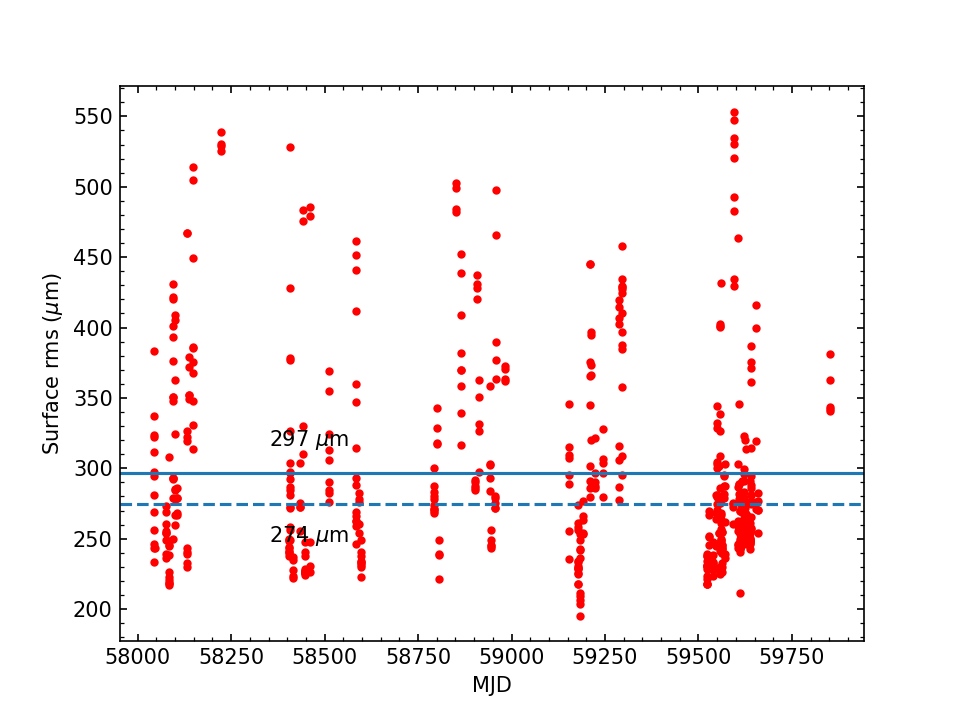

In [26]:
fig = plt.figure(dpi=150)
ax1 = fig.add_subplot(111)

ax1.plot(times1d[mask], aprms1d_[mask], 'r.')
#plt.plot(uoofmj1d, [250]*len(uoofmj1d), 'b.' )

avg = np.nanmean(aprms1d_[mask])
ax1.axhline(avg)
med = np.nanmedian(aprms1d_[mask])
ax1.axhline(med, ls="--")

inv = ax1.transData.inverted()
axt = ax1.transAxes
xt = inv.transform(axt.transform((0.2, 0)))[0]
#xt = inv.transform((0.5, 0))[0]
ax1.text(xt, avg*1.05, f'{avg:.0f} $\mu$m', transform=ax1.transData, va="bottom")
ax1.text(xt, med*0.95, f'{med:.0f} $\mu$m', transform=ax1.transData, va="top")


ax1.set_xlabel("MJD")
ax1.set_ylabel("Surface rms ($\mu$m)")
ax1.minorticks_on()
ax1.tick_params(which="both", direction="in", right=True, top=True)
#plt.savefig("surface_rms_mjd.png", bbox_inches="tight", pad_inches=0.03)

In [27]:
utc2et = dt.timedelta(hours = -5)
mjds = Time(times1d[mask], format="mjd") + utc2et
mjds_dt = mjds.datetime
hours = np.array([m.hour + m.minute/60 + m.second/3600. for m in mjds_dt])

<IPython.core.display.Javascript object>


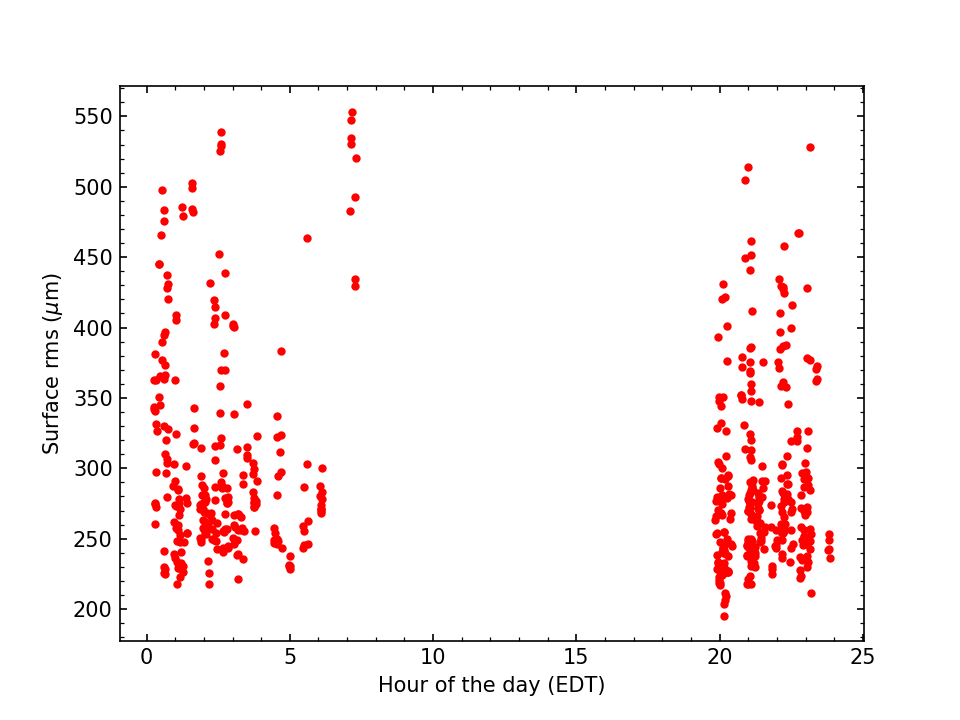

In [28]:
fig = plt.figure(dpi=150, frameon=False)
ax1 = fig.add_subplot(111)
ax1.plot(hours, aprms1d_[mask], 'r.')
ax1.set_xlabel("Hour of the day (EDT)")
ax1.set_ylabel("Surface rms ($\mu$m)")
ax1.minorticks_on()
ax1.tick_params(which="both", direction="in", right=True, top=True)
#plt.savefig("surface_rms_hourofday.png", bbox_inches="tight", pad_inches=0.03)

In [49]:
aosrc_m = aosrc1d[mask]
aosrcs = np.unique(aosrc_m)
cmap = plt.get_cmap("cool")
cmap = music_cmaps.endofsuffering
colors = cmap(np.linspace(0,1,len(aosrcs)))
cdict = dict.fromkeys(aosrcs)
for i,k in enumerate(aosrcs):
    cdict[k] = i
carr = np.array([colors[cdict[k]] for k in aosrc1d[mask]])
#color_arr = np.array()

<IPython.core.display.Javascript object>


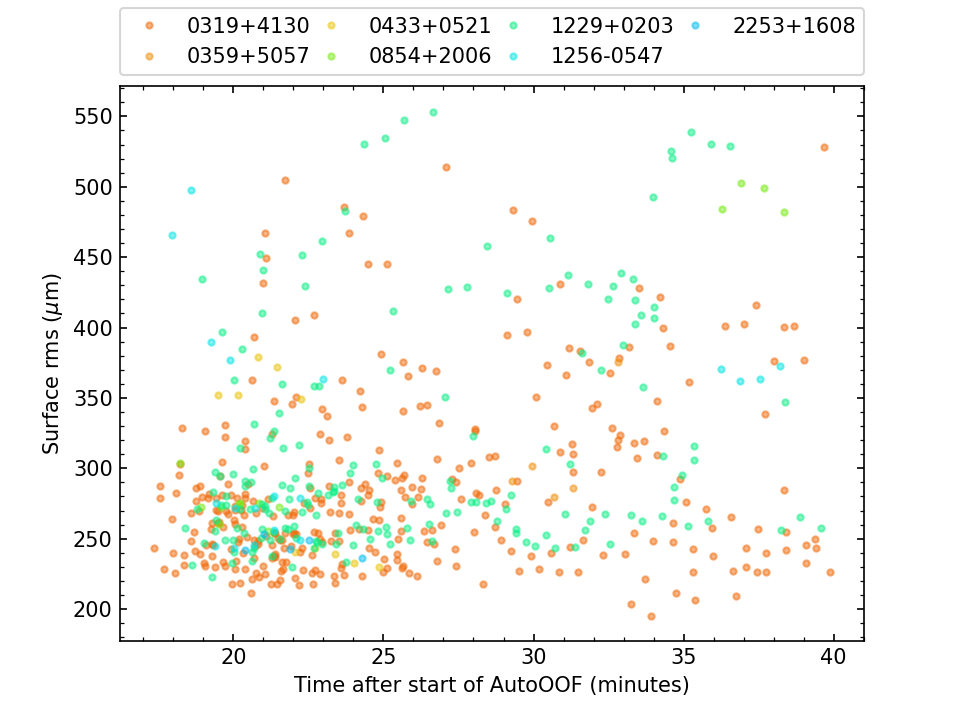

In [56]:
fig = plt.figure(dpi=150, frameon=False)
ax1 = fig.add_subplot(111)
for i,src in enumerate(aosrcs):
    mask_ = (aosrc_m == src)
    ax1.plot(dtime[mask][mask_], aprms1d_[mask][mask_], c=colors[cdict[src]], alpha=0.5, label=f"{src}", ls='', marker='.')

ax1.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
           mode="expand", borderaxespad=0, ncol=4)
ax1.set_xlabel("Time after start of AutoOOF (minutes)")
ax1.set_ylabel("Surface rms ($\mu$m)")
ax1.minorticks_on()
ax1.tick_params(which="both", direction="in", right=True, top=True)
plt.savefig("surface_rms_autoof_time_color_by_source.pdf", bbox_inches="tight", pad_inches=0.03)
#plt.scatter(dtime[mask], aprms1d_[mask], c=carr, alpha=0.5)

<IPython.core.display.Javascript object>


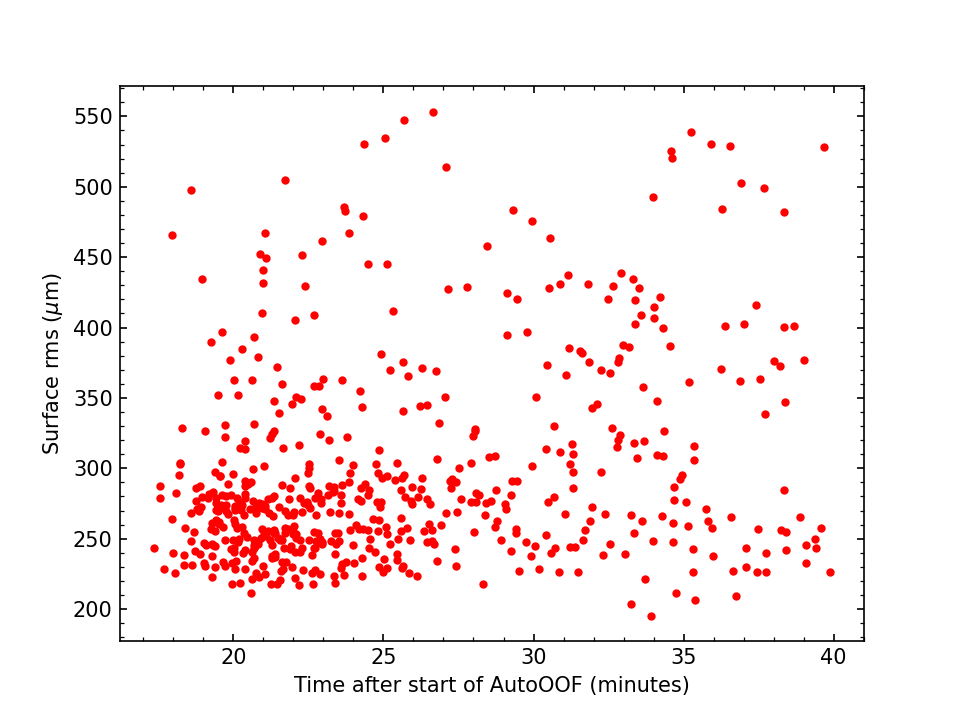

In [29]:
fig = plt.figure(dpi=150, frameon=False)
ax1 = fig.add_subplot(111)
ax1.plot(dtime[mask], aprms1d_[mask], 'r.')
ax1.set_xlabel("Time after start of AutoOOF (minutes)")
ax1.set_ylabel("Surface rms ($\mu$m)")
ax1.minorticks_on()
ax1.tick_params(which="both", direction="in", right=True, top=True)
#plt.savefig("surface_rms_autoof_time.png", bbox_inches="tight", pad_inches=0.03)

In [30]:
rms_cut = 250
rms_mask = (aprms1d_ < rms_cut)
print(f"{rms_mask.sum()}/{len(rms_mask)}")

355/1960


In [54]:
np.unique(projs1d[(rms_mask & mask)])

array(['AGBT18B_284_01', 'AGBT18B_284_02', 'AGBT18B_284_03',
       'AGBT18B_288_01', 'AGBT18B_357_02', 'AGBT19A_326_02',
       'AGBT19A_326_04', 'AGBT19B_302_02', 'AGBT20A_268_04',
       'AGBT20A_322_05', 'AGBT20A_322_06', 'AGBT20A_322_07',
       'AGBT20A_322_08', 'AGBT20A_322_17', 'AGBT20A_322_19',
       'AGBT20A_322_20', 'AGBT20A_322_21', 'AGBT20A_322_23',
       'AGBT20B_326_02', 'AGBT21B_024_08', 'AGBT21B_024_13',
       'AGBT21B_024_14', 'AGBT21B_024_15', 'AGBT21B_024_17',
       'AGBT21B_024_21', 'AGBT21B_024_22', 'AGBT21B_024_23',
       'AGBT21B_065_01', 'AGBT21B_228_01', 'AGBT21B_228_02',
       'AGBT21B_228_05', 'AGBT22A_044_01'], dtype='<U14')

In [31]:
rms_cut_projs = np.unique(projs1d[rms_mask])
rms_cut_scans = scans1d[rms_mask]
rms_cut_aoofs = aoofs1d[rms_mask]

In [32]:
len(rms_cut_projs)

47

In [51]:
rms_cut_scans, rms_cut_aoofs

(array([  9,  11,  20,  12,  19,   8,   9,  10,  11,  12,  39,  69,  70,
         88,  89,  94,   8,   9,  10,  11,  12,  13,  14,  16,  17,  13,
         14,  15,  16,  17,  13,  14,  16,   9,  10,  18,  19,  20,   8,
          9,  10,  11,  14,  15,  16,  17,  18,  11,  13,  14,  18,  19,
         23,  25,  10,  15,  17,  15,  17,  15,   8,   9,  10,  11,  14,
         15,  16,  17,  18,  45,  46,  47,   8,  12,  10,  12,  10,  11,
         12,   9,  10,  12,  15,  16,  17,  18,   8,   9,  10,  11,  12,
         15,  16,  17,  18,  55,  56,  59,  60,  61,  62,  65,  66,  67,
         68,  69,  94,  95,  96, 124, 126, 127,  11,   8,   9,  10,  11,
         12,  57,   8,   9,  10,  11,  12,  15,  16,  17,  18,  21,  22,
         23,  24,  25,  50,  52,  53,  54,  83,  10,  11,  12,  28,  44,
         45,   6,   7,  10,  47,  48,  49,  50,  51,  88,  89, 126, 166,
        107, 108, 109, 110, 148,  10,  11,  12,  13,  14,  51,  52,  53,
         99, 107, 108, 109, 110, 111, 107, 108, 109

In [33]:
# Add wind information.
dfw = pd.read_hdf("auto-oof-scans-15A_22A-wmeta-20092022.hdf", "auto-oof")

In [34]:
len(dfw), len(df)

(941, 941)

In [35]:
w2 = []
w3 = []
t2 = []
for i,(projid,oof_scan) in enumerate(zip(projs1d[(mask)], aoofs1d[(mask)])):
    pid = f"{projid}_s{oof_scan}"
    lidx = df.index[df["id"] == pid].tolist()
    print(lidx)
    w2.append(dfw["weather2_wind_avg"][lidx[0]])
    w3.append(dfw["weather3_wind_avg"][lidx[0]])
    t2.append(dfw["weather2_temp_avg"][lidx[0]])

[217]
[217]
[217]
[217]
[217]
[217]
[217]
[217]
[217]
[217]
[217]
[217]
[217]
[217]
[218]
[218]
[218]
[218]
[218]
[218]
[218]
[218]
[218]
[220]
[220]
[220]
[220]
[220]
[221]
[221]
[221]
[221]
[221]
[244]
[244]
[244]
[244]
[244]
[244]
[244]
[244]
[245]
[245]
[245]
[245]
[245]
[275]
[275]
[275]
[275]
[275]
[275]
[275]
[275]
[275]
[276]
[276]
[276]
[276]
[276]
[277]
[277]
[277]
[277]
[277]
[277]
[278]
[278]
[278]
[278]
[278]
[279]
[279]
[279]
[279]
[279]
[280]
[280]
[280]
[280]
[280]
[280]
[280]
[280]
[280]
[280]
[299]
[313]
[313]
[313]
[313]
[361]
[361]
[361]
[361]
[434]
[434]
[434]
[434]
[434]
[434]
[434]
[434]
[434]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[435]
[437]
[437]
[437]
[437]
[437]
[440]
[440]
[440]
[440]
[440]
[441]
[441]
[441]
[441]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[442]
[445]
[445]
[445]
[445]
[445]
[466]
[466]
[466]
[466]
[469]
[469]
[469]
[469]
[469]
[513]
[513]
[513]
[513

<IPython.core.display.Javascript object>


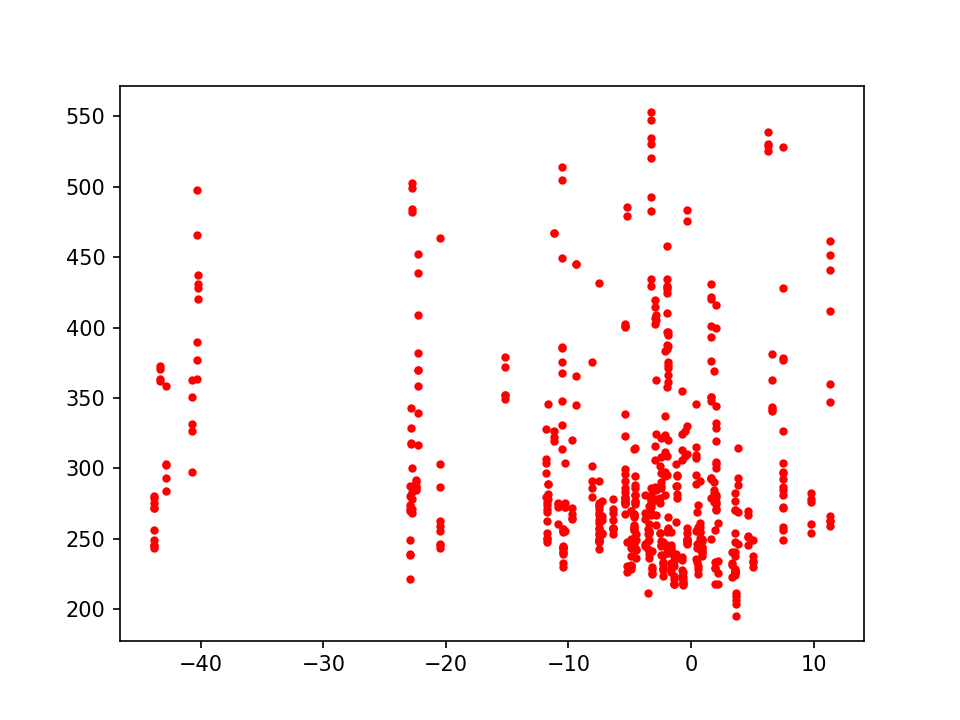

In [36]:
plt.figure(dpi=150)
plt.plot(t2, aprms1d_[mask], 'r.')

<IPython.core.display.Javascript object>


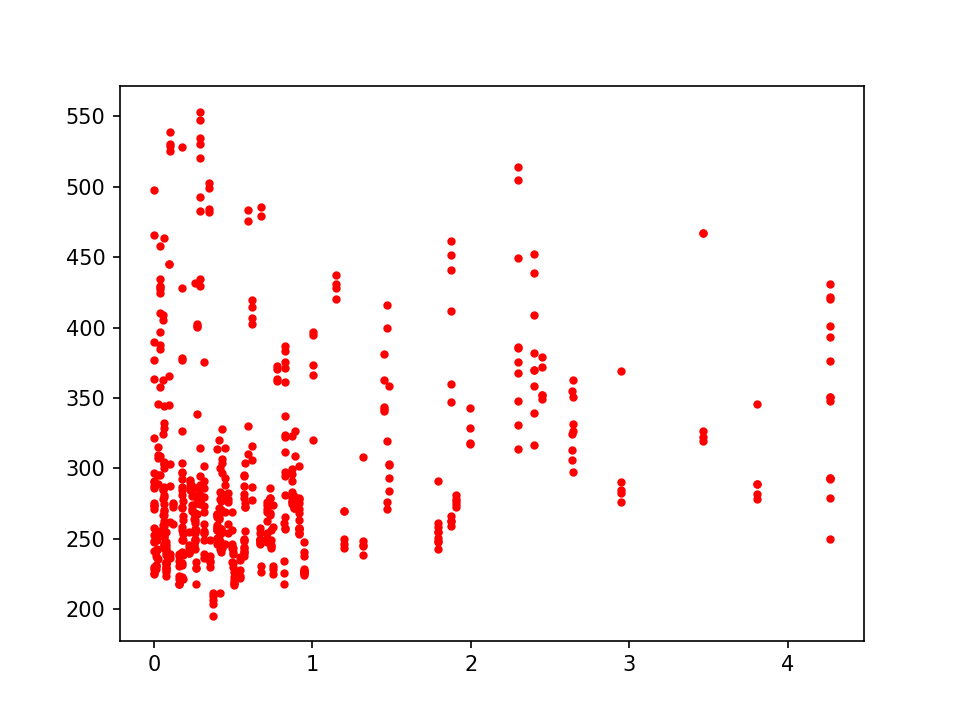

In [37]:
plt.figure(dpi=150)
plt.plot(w2, aprms1d_[mask], 'r.')

In [70]:
dfw["weather2_wind_avg"][0]

0.6799824237823486

In [57]:
z4 = thrmz1d[mask & rms_mask][:,3]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [61]:

np.asarray(thrmz1d[mask & rms_mask]).shape

(168,)

In [78]:
thrmz_arr = np.zeros((168,37), dtype=float)
for i,za in enumerate(thrmz1d[mask & rms_mask]):
    thrmz_arr[i,:] = np.hstack((0,za))
    
w2 = []
w3 = []
t2 = []
for i,(projid,oof_scan) in enumerate(zip(projs1d[(mask & rms_mask)], aoofs1d[(mask & rms_mask)])):
    pid = f"{projid}_s{oof_scan}"
    lidx = df.index[df["id"] == pid].tolist()
    w2.append(dfw["weather2_wind_avg"][lidx[0]])
    w3.append(dfw["weather3_wind_avg"][lidx[0]])
    t2.append(dfw["weather2_temp_avg"][lidx[0]])
    
t2 = np.asarray(t2)

In [82]:
tmask = (t2 > -20)

<IPython.core.display.Javascript object>


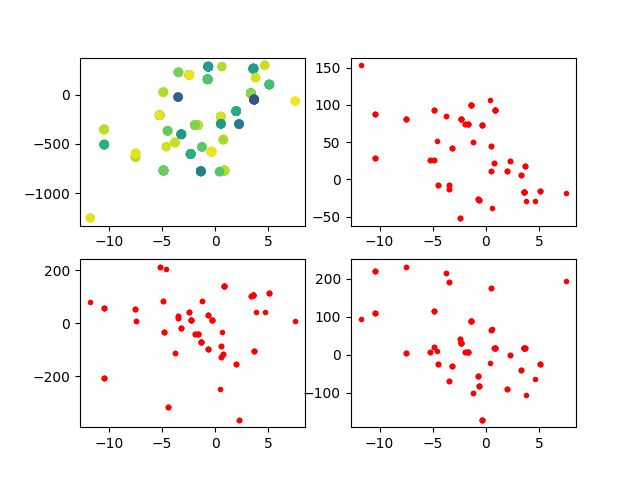

In [87]:
plt.figure()
plt.subplot(221)
plt.scatter(t2[tmask], thrmz_arr[tmask,4], c=aprms1d_[mask & rms_mask][tmask])
#plt.colorbar()
plt.subplot(222)
plt.plot(t2[tmask], thrmz_arr[tmask,5], 'r.')
plt.subplot(223)
plt.plot(t2[tmask], thrmz_arr[tmask,6], 'r.')
plt.subplot(224)
plt.plot(t2[tmask], thrmz_arr[tmask,7], 'r.')

<IPython.core.display.Javascript object>


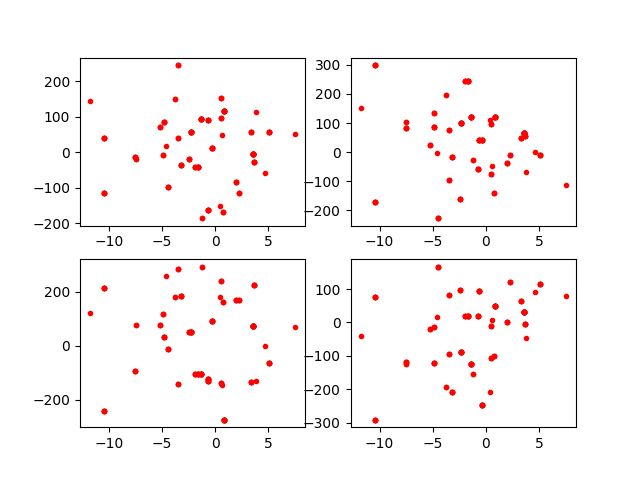

In [84]:
plt.figure()
plt.subplot(221)
plt.plot(t2[tmask], thrmz_arr[tmask,8], 'r.')
plt.subplot(222)
plt.plot(t2[tmask], thrmz_arr[tmask,9], 'r.')
plt.subplot(223)
plt.plot(t2[tmask], thrmz_arr[tmask,10], 'r.')
plt.subplot(224)
plt.plot(t2[tmask], thrmz_arr[tmask,11], 'r.')